In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from numpy import shape
import random

In [2]:
# Game of Life 
# die if less than two live neighbours
# survive if two or three live neighbours
# die if more than three live neighbours
# revive if three live neighbours

**Data Generation and Gathering**

In [3]:
# evolve board according certain laws, here the law is classical game of life
def evolve(board):
    output = np.zeros(board.shape)
    for x in range (board.shape[0]):
        for y in range (board.shape[1]):
            neighbours=count_neighbours(board,x,y)
            if ((board[x,y] == 0 and neighbours == 3) or (board[x,y] == 1 and 2 <= neighbours <= 3)):
                output[x,y] = 1
    return output

# count number of alive neighbours for each cell 
def count_neighbours(board,x,y):
    neighbours = -board[x,y]
    for i in (-1, 0, 1):
        for j in (-1, 0, 1):
            xi = (x + i) % board.shape[0] # impose periodic boundary conditions
            yj = (y + j) % board.shape[1]
            neighbours += board[xi,yj]
            if neighbours > 3:
                return neighbours
    return neighbours

# define the generator that generate training data for machine to learn
# sample_size: the number of sample pair generated each time the function is called
# board_size: the size of the board
# delay: wait for this much of time after initialization to take data 
def data_generator(sample_size, board_size, delay):
    while True:
        x_train=[]
        y_train=[]
        for i in range (sample_size):
            board = np.zeros((board_size, board_size, 1)) # binary boards are randomly initialized
            boards=[]
            d = random.uniform(0,1)
            #d=0.9
            for x in range(board_size):
                for y in range(board_size):
                    if random.uniform(0,1)<d:
                        board[x,y] = 1
            for i in range (delay):
                board = evolve(board)
            x_train.append(board)
            y_train.append(evolve(board))
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        yield x_train, y_train

**Constructing Model**

In [4]:
# construct the neural network
from keras.models import Sequential, Model
from keras.layers import Lambda
import keras.layers as layers

def cyclic_padding(board):
    cyclic_board_row = tf.concat([board, board[:, :1, :, :]], axis=1)
    cyclic_board_row = tf.concat([board[:, -1:, :, :], cyclic_board_row], axis=1)
    cyclic_board = tf.concat([cyclic_board_row, cyclic_board_row[:, :, :1, :]], axis=2)   
    cyclic_board = tf.concat([cyclic_board_row[:, :, -1:, :], cyclic_board], axis=2)   
    return cyclic_board

m=8
input_state = keras.Input(shape= (10, 10, 1)) # the input size needs to match the size specified in data_generator
x = cyclic_padding(input_state)
x = layers.Conv2D(2*m, (3, 3), activation='relu')(x) # convolution layer with two filters that extract features
x = layers.Conv2D(1*m, (1, 1), activation='relu')(x) # convolution layer with one filter that mixes the features from the first layer
output_state = layers.Conv2D(1, (1, 1), activation='sigmoid')(x) # a sigmoid layer that rescale the output, making grey site closer to be binary

model = Model(input_state, output_state)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 1, 10, 1)             0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 1, 10, 1)             0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                              

**Train Model**

In [5]:
# train the neural network 

keras.backend.clear_session() # refresh model each time

#model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.3), loss='mse')
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1), loss='binary_crossentropy')
history = model.fit(data_generator(1, 10, 5), epochs=100, steps_per_epoch=20)

Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 0.5176
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.3682
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 0.3790
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1783
Epoch 5/100
20/20 [==============================] - 0s 20ms/step - loss: 0.2905
Epoch 6/100
20/20 [==============================] - 0s 12ms/step - loss: 0.3133
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.2797
Epoch 8/100
20/20 [==============================] - 0s 13ms/step - loss: 0.1736
Epoch 9/100
20/20 [==============================] - 0s 12ms/step - loss: 0.2432
Epoch 10/100
20/20 [==============================] - 0s 13ms/step - loss: 0.2186
Epoch 11/100
20/20 [==============================] - 0s 14ms/step - loss: 0.1208
Epoch 12/100
20/20 [==============================] - 0s 12ms/step - loss: 0.2347
Epoch 13/100
20/20 [=====

**Testing Model**

1/1 [==============================] - 0s 20ms/step
* (10, 10, 1) <class 'numpy.ndarray'>
(3, 10, 10, 10, 1)


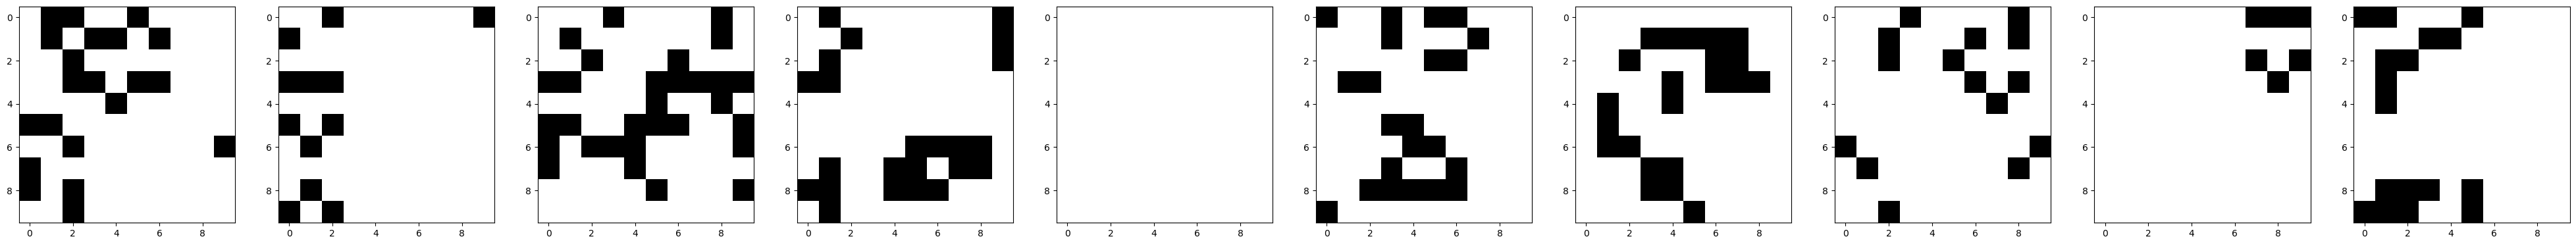

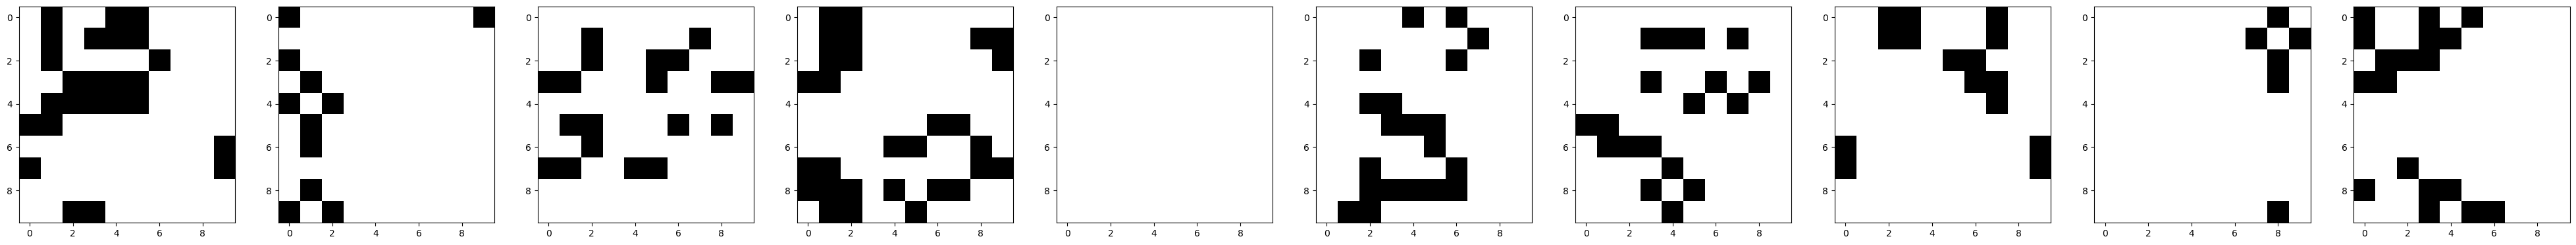

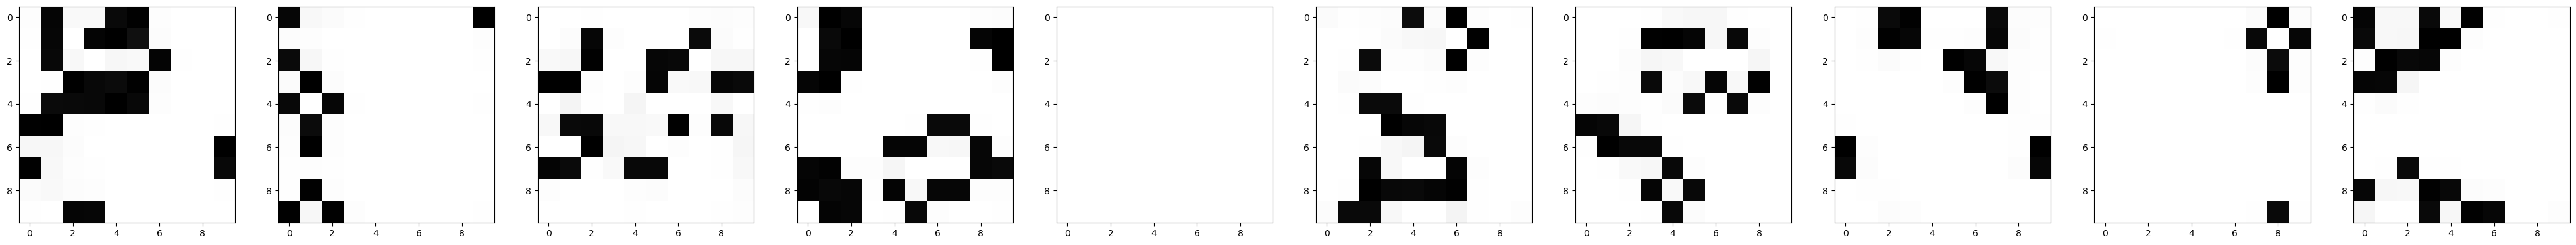

In [17]:
# generate test samples and verify the learning outcome

def board_generator(sample_size, board_size, delay):
    x_test=[]
    y_test=[]
    for i in range (sample_size):
        board = np.zeros((board_size, board_size, 1))
        boards=[]
        d = random.uniform(0.1,0.7)
        #d=0.9
        for x in range(board_size):
            for y in range(board_size):
                if random.uniform(0,1)<d:
                    board[x,y,0] = 1
        for i in range (delay):
            board = evolve(board)
        x_test.append(board)
        y_test.append(evolve(board))
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    y_pred = model.predict(x_test)
    return x_test, y_test, y_pred

data = board_generator(10,10,5)
print('*',data[i][j].shape, type(data[i][j]))
print(shape(data))
for i in range (len(data)):
    fig,ax=plt.subplots(1,shape(data[1])[0],figsize=(50, 50))
    for j in range (shape(data[1])[0]):
        ax[j].imshow(data[i][j],cmap=plt.cm.Greys)
        
# the first row is the test boards at time t 
# the second row is the corresponding test boards at time t+1
# the third row is the predicted boards at t+1 given by machine based on the test boards at time t